# Code to analyse compression ratio

21-02-2021 Guido Cattani, Revision 5 november 2022

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mannwhitneyu
from scipy.stats import shapiro as shapiro
from scipy.stats import ttest_ind as ttest_ind
from scipy.stats import levene as levene

In [2]:
# read compression ratio (CR) data
def read_CR():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Headband/Compression_ratio.xlsx'
    p_in = Path(f_in)   
    df = pd.read_excel(p_in, sheet_name='CR', header=0, nrows=85)
    df = df.drop(['Unnamed: 0'], axis=1)
    df = df.fillna(pd.NA)
    return df

In [3]:
# adjust column names, change format columns labels 'f_Hz' to f

data = read_CR()
clmns = data.columns
l = list()
for clm in clmns:
    l.append(clm)
l = l[2:]
l2 = list()
for s in l:
    s = s.rstrip('_Hz')
    f = int(s)
    l2.append(f)
d = dict()
d1 = dict()
for i in range(len(l)):
    d.update({l[i] : l2[i]})
    d1.update({l2[i] : l[i]})
data1 = data.drop(columns='Study_ID') # drop first column
data1 = data1.rename(columns=d)

In [4]:
# group data by device type and perform calculation of quantiles 10, 50, 90
dvc = data1.groupby('Device')
quantiles = [0.10, 0.50, 0.90]
q = dvc.quantile(q=quantiles)

# convert Pandas object in numpy array
frqc = np. array(l2 , dtype=int)
p10_bh5 = q.iloc[0].T.to_numpy()
median_bh5 = q.iloc[1].T.to_numpy()
p90_bh5 = q.iloc[2].T.to_numpy()
p10_bp110 = q.iloc[3].T.to_numpy()
median_bp110 = q.iloc[4].T.to_numpy()
p90_bp110 = q.iloc[5].T.to_numpy()

# select BP110 data and convert the Pandas Dataframe to numpy array
is_bp110 =  data1['Device']=='BP110'
cr_bp110 = data1[is_bp110]
dvc1 = cr_bp110.pop('Device')
bp110 = cr_bp110.T.to_numpy()

# select BAHA5P data and convert the Pandas Dataframe to numpy array
is_baha5p =  data1['Device']=='BAHA5P'
cr_baha5p = data1[is_baha5p]
dvc2 = cr_baha5p.pop('Device')
bh5 = cr_baha5p.T.to_numpy()

In [5]:
len(cr_bp110)

49

In [6]:
len(cr_baha5p)

36

In [7]:
q

250    315    400    500   630    800   1000   1250   1600  \
Device                                                                     
BAHA5P 0.1  1.020  0.930  0.870  0.895  0.89  0.895  0.920  0.930  0.935   
       0.5  1.115  1.115  1.035  0.950  0.93  0.930  0.950  0.975  0.995   
       0.9  1.225  1.290  1.180  1.080  1.05  1.005  0.995  1.055  1.090   
BP110  0.1  0.998  0.960  0.970  0.990  0.99  0.990  1.010  0.990  0.960   
       0.5  1.100  1.030  1.040  1.050  1.05  1.040  1.030  1.010  0.990   
       0.9  1.474  1.350  1.280  1.158  1.15  1.104  1.102  1.060  1.010   

             2000   2500   3150   4000   5000   6300   8000  
Device                                                       
BAHA5P 0.1  0.950  0.930  0.920  0.890  0.890  0.900  0.915  
       0.5  0.995  0.940  0.930  0.920  0.930  0.930  0.950  
       0.9  1.045  0.965  0.940  0.930  0.950  1.005  1.050  
BP110  0.1  0.938  0.930  0.910  0.906  0.910  0.910  0.940  
       0.5  0.960  0.950  0.930  0.930  0.930  0.940  0.970  
       0.9  0.990  0.970  0.952  0.950  0.952  0.960  1.004

In [8]:
# select data columns for violin plot with frequency 1 - 8 kHz  and convert data to numpy arrays

cr_bp110_hf = cr_bp110.drop(columns =[250, 315, 400, 500, 630, 800]) 
cr_baha5p_hf = cr_baha5p.drop(columns =[250, 315, 400, 500, 630, 800]) 
bp110_hf = cr_bp110_hf.to_numpy()
bh5_hf = cr_baha5p_hf.to_numpy()

In [9]:
# check normality output group BAHA5P & BP110 with Shapiro-Wilk test

shp = dict()

for i in range(0, 16):
    a = cr_baha5p.iloc[:, i]
    b = cr_bp110.iloc[:, i]
    f = l2[i]
    shapiro_stat_bh5, pVal_bh5 = shapiro(a) # bh5 scipy.stats Shapiro-Wilk test test
    shapiro_stat_bp110, pVal_bp110 = shapiro(b) # bp110 scipy.stats Shapiro-Wilk test test
    bh5_is_normal = False if pVal_bh5 < 0.05 else True
    bp110_is_normal = False if pVal_bp110 < 0.05 else True
    both_is_normal = True if bh5_is_normal and bp110_is_normal else False
    st = {f: [shapiro_stat_bh5, pVal_bh5, bh5_is_normal, shapiro_stat_bp110, pVal_bp110, bp110_is_normal, both_is_normal]}
    shp.update(st)

shapiro_test = pd.DataFrame.from_dict(shp)
dish =  {0: 'Shapiro test statistic BH5', 1: 'p-value BH5', 2: 'normally distributed in BH5', 3: 'Shapiro test statistic BP110', 
         4: 'p-value BP110', 5: 'normally distributed in BP110', 6: 'normally distributed in both groups'}
shapiro_test = shapiro_test.rename(index=dish)
shapiro_test

,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
Shapiro test statistic BH5,0.956564,0.952282,0.879734,0.794409,0.784782,0.821714,0.925904,0.920233,0.941558,0.944471,0.908082,0.854443,0.912565,0.944711,0.903633,0.937201
p-value BH5,0.168121,0.123389,0.000997,0.000013,0.000008,0.000045,0.018837,0.012788,0.056811,0.070078,0.005718,0.000241,0.007664,0.071304,0.004296,0.041594
normally distributed in BH5,True,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False
Shapiro test statistic BP110,0.832986,0.831909,0.85873,0.895568,0.912266,0.885436,0.9124,0.9059,0.94895,0.944485,0.955559,0.946042,0.885175,0.907952,0.925255,0.657096
p-value BP110,0.000007,0.000006,0.000032,0.000395,0.001417,0.00019,0.001432,0.000861,0.033495,0.022197,0.062218,0.025603,0.000187,0.00101,0.004098,0.0
normally distributed in BP110,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
normally distributed in both groups,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [10]:
# compare distribution cr BAHA5P vs. BP110 with Mann Whitney U test

mwu = dict()

for i in range(0, 16):
    a = cr_baha5p.iloc[:, i]
    b = cr_bp110.iloc[:, i]
    f = l2[i]
    # scipy.stats mannwhitneyu test
    u_statistic, pVal = mannwhitneyu(a , b, use_continuity=False, alternative='two-sided') 
    pVal = round(pVal, 15)
    st = {f: [u_statistic, pVal]}
    mwu.update(st)
u_test = pd.DataFrame.from_dict(mwu, dtype='float')

In [11]:
# join percentiles & U-test and present both in table

q= q.round(decimals=2)
q = q.reset_index()
diq = {0:'BAHA5P P10', 1:'BAHA5P P50', 2:'BAHA5P P90', 
      3:'BP110 P10', 4:'BP110 P50', 5:'BP110 P90'} 

q = q.rename(index=diq)
q = q.drop(['Device', 'level_1'], axis=1)

diu =  {0: 'Mann-Whitney U statistic', 1: 'p-value (two-sided)'}
u_test = u_test.rename(index=diu)
u_test

analysis_cr = pd.concat([q, shapiro_test, u_test])

analysis_cr = analysis_cr.rename(columns=d1)

# write to xlsx file
analysis_cr.to_excel("/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/analysis_compressio_ratio.xlsx",
                         sheet_name='cr_BAHA5_vs_BP110')  

analysis_cr

,250_Hz,315_Hz,400_Hz,500_Hz,630_Hz,800_Hz,1000_Hz,1250_Hz,1600_Hz,2000_Hz,2500_Hz,3150_Hz,4000_Hz,5000_Hz,6300_Hz,8000_Hz
BAHA5P P10,1.02,0.93,0.87,0.9,0.89,0.9,0.92,0.93,0.94,0.95,0.93,0.92,0.89,0.89,0.9,0.92
BAHA5P P50,1.12,1.12,1.04,0.95,0.93,0.93,0.95,0.98,1.0,1.0,0.94,0.93,0.92,0.93,0.93,0.95
BAHA5P P90,1.23,1.29,1.18,1.08,1.05,1.0,1.0,1.06,1.09,1.04,0.96,0.94,0.93,0.95,1.0,1.05
BP110 P10,1.0,0.96,0.97,0.99,0.99,0.99,1.01,0.99,0.96,0.94,0.93,0.91,0.91,0.91,0.91,0.94
BP110 P50,1.1,1.03,1.04,1.05,1.05,1.04,1.03,1.01,0.99,0.96,0.95,0.93,0.93,0.93,0.94,0.97
BP110 P90,1.47,1.35,1.28,1.16,1.15,1.1,1.1,1.06,1.01,0.99,0.97,0.95,0.95,0.95,0.96,1.0
Shapiro test statistic BH5,0.956564,0.952282,0.879734,0.794409,0.784782,0.821714,0.925904,0.920233,0.941558,0.944471,0.908082,0.854443,0.912565,0.944711,0.903633,0.937201
p-value BH5,0.168121,0.123389,0.000997,0.000013,0.000008,0.000045,0.018837,0.012788,0.056811,0.070078,0.005718,0.000241,0.007664,0.071304,0.004296,0.041594
normally distributed in BH5,True,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False
Shapiro test statistic BP110,0.832986,0.831909,0.85873,0.895568,0.912266,0.885436,0.9124,0.9059,0.94895,0.944485,0.955559,0.946042,0.885175,0.907952,0.925255,0.657096


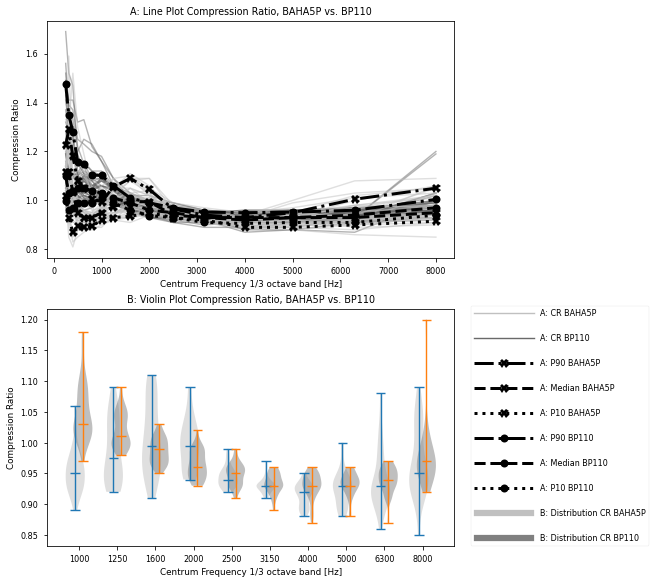

In [12]:
# make a figure to plot otput baha5 vs. BP110

plt.style.use('seaborn-paper')
plt.rcParams['axes.facecolor'] = 'white'

fig, (ax, ax1) = plt.subplots(2, constrained_layout=True)

fig.set_figheight(8)
fig.set_figwidth(9)


# make the line plot

ax.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Compression Ratio',
       title='A: Line Plot Compression Ratio, BAHA5P vs. BP110')

# plot lines based on numpy arrays
ax.plot(frqc, bp110, color="dimgrey", alpha=0.5, label='cr FL BP110')
ax.plot(frqc, bh5, color="silver", alpha=0.5, label='cr FL BAHA5P')
ax.plot(frqc, median_bp110, color='black', marker='o', linestyle='dashed', linewidth=3, markersize=8)
ax.plot(frqc, p10_bp110, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=8)
ax.plot(frqc, p90_bp110, color='black', marker='o', linestyle='dashdot', linewidth=3, markersize=8)
ax.plot(frqc, median_bh5, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=9)
ax.plot(frqc, p10_bh5, color='black', marker='X', linestyle='dotted', linewidth=3, markersize=9)
ax.plot(frqc, p90_bh5, color='black', marker='X', linestyle='dashdot', linewidth=3, markersize=9)


# make the violin plot

xi = list(range(1, 11))
x = list(cr_bp110_hf.columns)


ax1.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Compression Ratio', 
        title='B: Violin Plot Compression Ratio, BAHA5P vs. BP110')

ax1.set_xticks(xi)
ax1.set_xticklabels(x)

viol1 = ax1.violinplot(bh5_hf, positions=[0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 6.9, 7.9, 8.9, 9.9], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol1['bodies']:
    pc.set_facecolor('silver')
    pc.set_alpha(0.5)


viol2 = ax1.violinplot(bp110_hf, positions=[1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1, 10.1], 
                       showmeans=False, showmedians=True, showextrema=True)

for pc in viol2['bodies']:
    pc.set_facecolor('grey')
    pc.set_alpha(0.5)

    
# make a legend
leg_line_BH5 = mlines.Line2D([], [], color="silver", label='A: CR BAHA5P')
leg_line_BP110 = mlines.Line2D([], [], color="dimgrey", label='A: CR BP110')

leg_p90_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='A: P90 BAHA5P')
leg_med_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='A: Median BAHA5P')
leg_p10_bh5 = mlines.Line2D([], [], color='black', marker='X', linestyle='dotted', 
                            linewidth=3, markersize=9, label='A: P10 BAHA5P')
leg_p90_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashdot', 
                              linewidth=3, markersize=8, label='A: P90 BP110')
leg_med_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dashed', 
                              linewidth=3, markersize=8, label='A: Median BP110')
leg_p10_bp110 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                              linewidth=3, markersize=8, label='A: P10 BP110')
leg_patch_BH5 = mpatches.Patch(color="silver", label='B: Distribution CR BAHA5P')
leg_patch_BP110 = mpatches.Patch(color="grey", label='B: Distribution CR BP110')      

leg = plt.legend(handles=[leg_line_BH5, leg_line_BP110, leg_p90_bh5, leg_med_bh5, leg_p10_bh5, leg_p90_bp110, 
                        leg_med_bp110, leg_p10_bp110, leg_patch_BH5, leg_patch_BP110], 
                 bbox_to_anchor=(1.03, 1.03), loc='upper left', labelspacing=2., handlelength=7.5)


# save figure to file
plt.savefig('/media/guido/LACIE/Cingle_Guido/Project_band/Analysis_results/compression_ratio.tiff', 
           transparent=False, dpi=500, bbox_inches="tight")

plt.show() # show the figure